   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

=

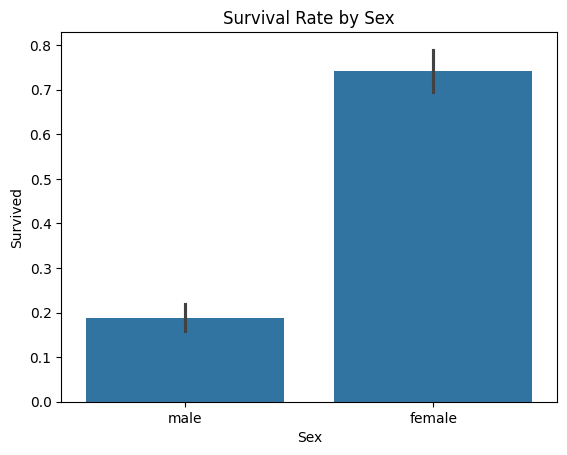

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. 加载数据
# 确保 train.csv 和 test.csv 都在 dataset 文件夹里
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

# 2. 看看数据长啥样
print(train_df.head())

# 3. 找茬：看看哪些列缺数据？
print("\n=== 缺失值统计 ===")
print(train_df.isnull().sum())

# 可视化一下：女性和男性的生存率对比
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title("Survival Rate by Sex")
plt.show()

In [4]:
# === 修复版预处理函数 ===
def preprocess_data(df):
    # 1. 填补年龄：用平均值
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    
    # 2. 填补港口：用最多的 'S'
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # 3. 【新增】填补票价：用中位数 (防止 Test 集报错的关键！)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # 4. 翻译性别
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # 5. 翻译港口
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # 6. 丢弃无关列
    df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
    
    return df

# === 重新执行预处理 ===
# 记得重新读取数据，防止重复操作报错
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

# 备份 ID 用于提交
test_passenger_ids = test_df['PassengerId']

# 清洗数据
train_clean = preprocess_data(train_df)
test_clean = preprocess_data(test_df)

# === 验证环节 (非常重要) ===
# 检查现在 Test 集里还有没有空值？应该是 0 才对
print("Test集剩余空值数量:\n", test_clean.isnull().sum())
print("-" * 30)
print("数据形状:", train_clean.shape)

Test集剩余空值数量:
 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
------------------------------
数据形状: (891, 8)


In [5]:
# 1. 准备数据
X = train_clean.drop('Survived', axis=1) # 特征
y = train_clean['Survived']              # 目标（0死，1活）

# 2. 拆分出一个小的验证集，自己先测测准不准
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 召唤逻辑回归模型
model = LogisticRegression(max_iter=1000) # max_iter大一点防止报错
model.fit(X_train, y_train)

# 4. 自己考自己：在验证集上看看准确率
val_predictions = model.predict(X_val)
acc = accuracy_score(y_val, val_predictions)
print(f"✅ 我的模型准确率: {acc:.2%}") 

# 5. 正式考试：预测 Test 集
final_predictions = model.predict(test_clean)

# 6. 生成提交文件
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': final_predictions
})
submission.to_csv('titanic_submission.csv', index=False)
print("🎉 文件已生成: titanic_submission.csv，快去 Kaggle 提交吧！")

✅ 我的模型准确率: 79.89%
🎉 文件已生成: titanic_submission.csv，快去 Kaggle 提交吧！


=== 模型眼里的生存法则 ===
    Feature    Weight
1       Sex  2.580670
6  Embarked  0.234413
5      Fare  0.002817
2       Age -0.031978
4     Parch -0.103973
3     SibSp -0.304638
0    Pclass -0.961168


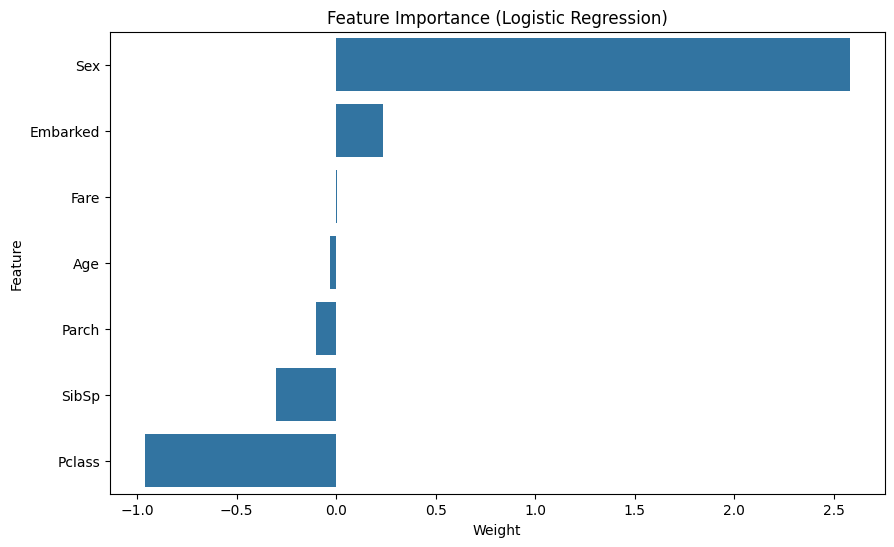

In [6]:
# 获取特征名称
feature_names = X.columns
# 获取模型学到的权重 (Coefficients)
coefficients = model.coef_[0]

# 做成一个 DataFrame 方便看
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients
})

# 按权重绝对值排序，看看谁影响最大
coeff_df = coeff_df.sort_values(by='Weight', ascending=False)

print("=== 模型眼里的生存法则 ===")
print(coeff_df)

# 画个图直观一点
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coeff_df)
plt.title("Feature Importance (Logistic Regression)")
plt.show()